In [1]:
import os
# os.environ['HF_HOME'] = r"D:\.cache\hf"
import numpy as np
import torch
from torch import nn
from PIL import Image
import requests
from transformers import AutoModel, AutoProcessor
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.mask_rcnn import MaskRCNN, RPNHead, MaskRCNNHeads, MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import AnchorGenerator, FastRCNNPredictor, FastRCNNConvFCHead
from torchvision.ops import FeaturePyramidNetwork
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import zipfile
from tqdm import tqdm
import logging
from pycocotools import mask as coco_mask

from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor

seed_everything(42)
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.enabled = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True 

Seed set to 42


In [2]:
torch._dynamo.list_backends()

/home/vamsik1211/Data/miniconda3/envs/main/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/vamsik1211/Data/miniconda3/envs/main/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'tvm']

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [4]:
device

'cuda'

In [5]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Download COCO 2017 dataset to D drive
BASE_DIR = "/home/vamsik1211/Data/Assignments/Sem-2/CV/CourseProject/Instance_Segmentation Code CV Project/dataset/coco"
COCO_URLS = {
    "train2017": "http://images.cocodataset.org/zips/train2017.zip",
    "val2017": "http://images.cocodataset.org/zips/val2017.zip",
    "test2017": "http://images.cocodataset.org/zips/test2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

def download_file(url, dest_path):
    try:
        logger.info(f"Starting download: {url} to {dest_path}")
        response = requests.get(url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 * 1024
        with open(dest_path, 'wb') as file, tqdm(
            desc=os.path.basename(dest_path),
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(block_size):
                size = file.write(data)
                bar.update(size)
        logger.info(f"Download completed: {dest_path} ({total_size / (1024*1024):.2f} MB)")
    except requests.exceptions.RequestException as e:
        logger.error(f"Failed to download {url}: {e}")
        raise
    except IOError as e:
        logger.error(f"Failed to write to {dest_path}: {e}")
        raise

def extract_zip(zip_path, extract_to):
    try:
        logger.info(f"Extracting {zip_path} to {extract_to}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(zip_path)
        logger.info(f"Extracted and removed {zip_path}")
    except zipfile.BadZipFile as e:
        logger.error(f"Bad zip file: {zip_path} - {e}")
        raise
    except OSError as e:
        logger.error(f"Failed to extract or remove {zip_path}: {e}")
        raise

def download_coco_dataset(base_dir=BASE_DIR):
    images_dir = os.path.join(base_dir, "images")
    annotations_dir = os.path.join(base_dir, "annotations")
    if not os.path.exists(base_dir):
        os.makedirs(images_dir)
        os.makedirs(annotations_dir)
        logger.info(f"Created directories: {images_dir}, {annotations_dir}")
    else:
        logger.info(f"Directory {base_dir} already exists. Checking contents...")
    required_dirs = {
        "train2017": os.path.join(images_dir, "train2017"),
        "val2017": os.path.join(images_dir, "val2017"),
        "test2017": os.path.join(images_dir, "test2017"),
        "annotations": annotations_dir
    }
    all_complete = True
    for key, dir_path in required_dirs.items():
        if not os.path.exists(dir_path) or not os.listdir(dir_path):
            all_complete = False
            logger.info(f"{key} missing or empty at {dir_path}")
            break
        else:
            logger.info(f"{key} found at {dir_path} with {len(os.listdir(dir_path))} files")
    if not all_complete:
        for key, url in COCO_URLS.items():
            dest_dir = annotations_dir if key == "annotations" else images_dir
            zip_path = os.path.join(dest_dir, f"{key}.zip")
            extracted_folder = os.path.join(dest_dir, key if key != "annotations" else "")
            if os.path.exists(extracted_folder) and os.listdir(extracted_folder):
                logger.info(f"{key} already downloaded and extracted to {extracted_folder}. Skipping...")
                continue
            download_file(url, zip_path)
            extract_zip(zip_path, dest_dir)
        logger.info(f"COCO 2017 dataset successfully downloaded and extracted to {base_dir}")
    else:
        logger.info("COCO 2017 dataset appears complete. Skipping download.")

In [6]:
# Model definition
class SamEmbeddingModelWithFPN(nn.Module):
    def __init__(self, model_name=None):
        super().__init__()
        model = AutoModel.from_pretrained(model_name)
        self.model = model.vision_encoder
        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256],
            out_channels=256,
            extra_blocks=None
        )
    
    def forward(self, inputs):
        if isinstance(inputs, dict):
            inputs = inputs["pixel_values"]
        output = self.model(inputs)["last_hidden_state"]
        features = {"0": output}
        fpn_output = self.fpn(features)
        return fpn_output

def freeze_model(model: torch.nn.Module):
    for param in model.parameters():
        param.requires_grad = False


In [7]:
from fastprogress.fastprogress import master_bar, progress_bar

def train_model(model, train_loader, val_loader, num_epochs=10, gradient_accumulation_steps=4):

    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    scaler = torch.amp.GradScaler()  # Use GradScaler for mixed precision training
    
    mb = master_bar(range(num_epochs))  # Master bar for epochs
    for epoch in mb:
        print(f"Epoch {epoch+1}/{num_epochs}")
        running_loss = 0.0
        optimizer.zero_grad()  # Reset gradients at the start of each epoch
        
        pb = progress_bar(enumerate(train_loader), parent=mb, total=len(train_loader))  # Progress bar for batches
        model.train()
        for i, (images, targets) in pb:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            with torch.amp.autocast(dtype=torch.float16, device_type=device):  # Use autocast for mixed precision
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                losses = losses / gradient_accumulation_steps  # Scale the loss for accumulation
            
            scaler.scale(losses).backward()  # Scale the loss for mixed precision
            
            # Gradient accumulation
            if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Reset gradients after optimizer step
            
            running_loss += losses.item() * gradient_accumulation_steps  # Multiply back to get the actual loss
            pb.comment = f"Batch {i}, Loss: {losses.item() * gradient_accumulation_steps:.4f}"  # Update progress bar comment
        
        epoch_loss = running_loss / len(train_loader)
        mb.write(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        
        # Validation loop
        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for images, targets in val_loader:
        #         images = list(image.to(device) for image in images)
        #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
        #         with torch.amp.autocast(device_type=device, dtype=torch.float16):
        #             loss_dict = model(images, targets)
        #             print(loss_dict)
        #             losses = sum(loss for loss in loss_dict.values())
                
        #         val_loss += losses.item()
        
        # val_loss /= len(val_loader)
        # mb.write(f"Validation Loss: {val_loss:.4f}")
        # model.train()

In [8]:
from torch.optim.lr_scheduler import OneCycleLR
from fastprogress.fastprogress import master_bar, progress_bar

def train_model_with_onecyclelr(
    model, train_loader, val_loader, num_epochs=10, gradient_accumulation_steps=4
):
    """
    Train the model using OneCycleLR scheduler and mixed precision training.
    """
    # Define optimizer
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005
    )

    # Define OneCycleLR scheduler
    total_steps = len(train_loader) * num_epochs // gradient_accumulation_steps
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.005,
        total_steps=total_steps,
        pct_start=0.3,  # Percentage of the cycle spent increasing the learning rate
        # anneal_strategy="linear",
        final_div_factor=1e5,  # Determines the minimum learning rate
    )

    # Use GradScaler for mixed precision training
    scaler = torch.amp.GradScaler()

    # Progress bar for epochs
    mb = master_bar(range(num_epochs))
    for epoch in mb:
        print(f"Epoch {epoch + 1}/{num_epochs}")
        running_loss = 0.0
        optimizer.zero_grad()  # Reset gradients at the start of each epoch

        # Progress bar for batches
        pb = progress_bar(enumerate(train_loader), parent=mb, total=len(train_loader))
        model.train()
        for i, (images, targets) in pb:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Mixed precision training with autocast
            with torch.amp.autocast(dtype=torch.float16, device_type=device):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                losses = losses / gradient_accumulation_steps  # Scale the loss for accumulation

            # Backpropagation with scaled loss
            scaler.scale(losses).backward()

            # Gradient accumulation
            if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)  # Update weights
                scaler.update()  # Update scaler
                optimizer.zero_grad()  # Reset gradients after optimizer step
                scheduler.step()  # Update learning rate

            # Track running loss
            running_loss += losses.item() * gradient_accumulation_steps  # Multiply back to get the actual loss
            pb.comment = f"Batch {i}, Loss: {losses.item() * gradient_accumulation_steps:.4f}, Current LR: {scheduler.get_last_lr()}"  # Update progress bar comment

        # Epoch loss
        epoch_loss = running_loss / len(train_loader)
        mb.write(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}")

        # Validation loop
        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for images, targets in val_loader:
        #         images = list(image.to(device) for image in images)
        #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #         with torch.cuda.amp.autocast(dtype=torch.float16, device_type=device):
        #             loss_dict = model(images, targets)
        #             losses = sum(loss for loss in loss_dict.values())

        #         val_loss += losses.item()

        # val_loss /= len(val_loader)
        # mb.write(f"Validation Loss: {val_loss:.4f}")
        model.train()

In [9]:
from lightning import LightningModule
import torch

class InstanceSegmentationModel(LightningModule):
    def __init__(self, model, learning_rate=0.005, weight_decay=0.0005, momentum=0.9, max_epochs=10):
        super(InstanceSegmentationModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.max_epochs = max_epochs

    def forward(self, images, targets=None):
        # Forward pass
        return self.model(images, targets)

    def training_step(self, batch):
        images, targets = batch
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    # def validation_step(self, batch):
    #     images, targets = batch
    #     images = list(image.to(self.device) for image in images)
    #     targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
    #     loss_dict = self.model(images, targets)
    #     loss = sum(loss for loss in loss_dict.values())
    #     self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    #     return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=self.learning_rate,
            momentum=self.momentum,
            weight_decay=self.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            steps_per_epoch=self.trainer.estimated_stepping_batches // self.max_epochs,
            epochs=self.max_epochs,
            anneal_strategy='linear'
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [10]:
COCO_CLASSES = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

In [11]:
# def resize_and_pad_image(image, target_size=(1024, 1024)):
#     img_array = np.array(image)
#     h, w = img_array.shape[:2]
#     scale = min(target_size[0] / h, target_size[1] / w)
#     new_h, new_w = int(h * scale), int(w * scale)
#     resized = Image.fromarray(img_array).resize((new_w, new_h), Image.Resampling.LANCZOS)
#     resized_array = np.array(resized)
#     padded = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
#     top = (target_size[0] - new_h) // 2
#     left = (target_size[1] - new_w) // 2
#     padded[top:top+new_h, left:left+new_w] = resized_array
#     return Image.fromarray(padded)

# def generate_masks(image_path):
#     image = Image.open(image_path).convert("RGB")
#     processed_image = resize_and_pad_image(image)
#     img_array = np.array(processed_image).transpose(2, 0, 1)
#     img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device) / 255.0
#     images = [img_tensor]
#     with torch.no_grad():
#         predictions = seg_model(images)
#     masks = predictions[0]['masks']
#     scores = predictions[0]['scores']
#     labels = predictions[0]['labels']
#     score_threshold = 0.1
#     valid_indices = scores > score_threshold
#     valid_masks = masks[valid_indices]
#     valid_scores = scores[valid_indices]
#     valid_labels = labels[valid_indices]
#     binary_masks = (valid_masks > 0.1).squeeze(1).cpu().numpy()
#     return binary_masks, image, processed_image, {'scores': valid_scores, 'labels': valid_labels}

# def collate_fn(batch):
#     images = [item[0] for item in batch]
#     targets = [item[1] for item in batch]
#     processed_targets = []
#     target_size = (1024, 1024)
    
#     for idx, target_list in enumerate(targets):
#         if not target_list:
#             processed_targets.append({
#                 'boxes': torch.empty((0, 4), dtype=torch.float32),
#                 'labels': torch.empty(0, dtype=torch.int64),
#                 'masks': torch.empty((0, *target_size), dtype=torch.uint8),
#                 'area': torch.empty(0, dtype=torch.float32),
#                 'iscrowd': torch.empty(0, dtype=torch.uint8)
#             })
#         else:
#             orig_h, orig_w = batch[idx][0].shape[-2], batch[idx][0].shape[-1]
#             scale_h, scale_w = target_size[0] / orig_h, target_size[1] / orig_w
            
#             target_dict = {
#                 'boxes': torch.tensor([t['bbox'] for t in target_list], dtype=torch.float32),
#                 'labels': torch.tensor([t['category_id'] for t in target_list], dtype=torch.int64),
#                 'area': torch.tensor([t['area'] for t in target_list], dtype=torch.float32),
#                 'iscrowd': torch.tensor([t['iscrowd'] for t in target_list], dtype=torch.uint8)
#             }
#             boxes = target_dict['boxes']
#             target_dict['boxes'] = torch.stack([
#                 boxes[:, 0] * scale_w, boxes[:, 1] * scale_h,
#                 (boxes[:, 0] + boxes[:, 2]) * scale_w, (boxes[:, 1] + boxes[:, 3]) * scale_h
#             ], dim=1)
            
#             # Filter out invalid bounding boxes
#             valid_boxes = (target_dict['boxes'][:, 2] > target_dict['boxes'][:, 0]) & \
#                           (target_dict['boxes'][:, 3] > target_dict['boxes'][:, 1])
#             target_dict['boxes'] = target_dict['boxes'][valid_boxes]
#             target_dict['labels'] = target_dict['labels'][valid_boxes]
#             target_dict['area'] = target_dict['area'][valid_boxes]
#             target_dict['iscrowd'] = target_dict['iscrowd'][valid_boxes]
            
#             masks = []
#             for t, valid in zip(target_list, valid_boxes):
#                 if not valid:
#                     continue
#                 seg = t['segmentation']
#                 try:
#                     if isinstance(seg, dict):  # RLE format
#                         # Handle uncompressed RLE (list of integers)
#                         if isinstance(seg['counts'], list):
#                             rle = {'counts': seg['counts'], 'size': [orig_h, orig_w]}
#                             mask = coco_mask.decode(coco_mask.frPyObjects(rle, orig_h, orig_w))
#                         else:  # Compressed RLE (bytes)
#                             mask = coco_mask.decode(seg)
#                     elif isinstance(seg, list):  # Polygon format
#                         rle = coco_mask.frPyObjects(seg, orig_h, orig_w)
#                         if isinstance(rle, list):
#                             mask_stack = [coco_mask.decode(r) for r in rle]
#                             mask = np.any(mask_stack, axis=0).astype(np.uint8)
#                         else:
#                             mask = coco_mask.decode(rle)
#                     else:
#                         raise ValueError(f"Unexpected segmentation format: {type(seg)}")
                    
#                     if mask.ndim == 3:
#                         mask = np.any(mask, axis=2).astype(np.uint8)
#                     elif mask.ndim != 2:
#                         logger.warning(f"Invalid mask dim {mask.ndim}, using zero mask")
#                         mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
                    
#                     if mask.shape != (orig_h, orig_w):
#                         logger.warning(f"Mask shape {mask.shape} != ({orig_h}, {orig_w}), using zero mask")
#                         mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
                    
#                     mask_img = Image.fromarray(mask, mode='L').resize(target_size, Image.Resampling.NEAREST)
#                     masks.append(np.array(mask_img, dtype=np.uint8))
#                 except Exception as e:
#                     logger.error(f"Error processing segmentation: {e}, seg type: {type(seg)}, using zero mask")
#                     masks.append(np.zeros(target_size, dtype=np.uint8))
#             target_dict['masks'] = torch.tensor(np.stack(masks), dtype=torch.uint8)
            
#             processed_targets.append(target_dict)
#     return images, processed_targets

# class ResizeAndPad:
#     def __init__(self, target_size=(1024, 1024)):
#         self.target_size = target_size
    
#     def __call__(self, image):
#         return resize_and_pad_image(image, self.target_size)


# if __name__ == "__main__":
#     download_coco_dataset()
    
#     train_dir = r"dataset/coco/images/train2017"
#     val_dir = r"dataset/coco/images/val2017"
#     train_ann = r"dataset/coco/annotations/annotations/instances_train2017.json"
#     val_ann = r"dataset/coco/annotations/annotations/instances_val2017.json"
#     for path in [train_dir, val_dir, train_ann, val_ann]:
#         if not os.path.exists(path):
#             raise FileNotFoundError(f"Required dataset file/directory not found: {path}")
#         logger.info(f"Verified existence of {path}")

#     model_name = "Zigeng/SlimSAM-uniform-77"
#     backbone = SamEmbeddingModelWithFPN(model_name=model_name).eval()
#     freeze_model(backbone)
    
#     anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
#     roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#     mask_roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)
#     box_head = FastRCNNConvFCHead((backbone.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d)
#     mask_head = MaskRCNNHeads(backbone.out_channels, [256, 256, 256, 256], 1, norm_layer=nn.BatchNorm2d)
#     box_predictor = FastRCNNPredictor(in_channels=1024, num_classes=91)
#     rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], conv_depth=2)
#     mask_predictor = MaskRCNNPredictor(in_channels=256, dim_reduced=256, num_classes=91)
    
#     seg_model = MaskRCNN(
#         backbone=backbone,
#         num_classes=None,
#         min_size=1024,
#         max_size=1024,
#         rpn_anchor_generator=anchor_generator,
#         rpn_head=rpn_head,
#         rpn_pre_nms_top_n_train=300,
#         rpn_pre_nms_top_n_test=300,
#         rpn_post_nms_top_n_train=300,
#         rpn_post_nms_top_n_test=300,
#         rpn_nms_thresh=0.7,
#         rpn_fg_iou_thresh=0.7,
#         rpn_bg_iou_thresh=0.3,
#         rpn_batch_size_per_image=256,
#         rpn_positive_fraction=0.5,
#         box_roi_pool=roi_pooler,
#         box_head=box_head,
#         box_predictor=box_predictor,
#         box_score_thresh=0.05,
#         box_nms_thresh=0.5,
#         box_detections_per_img=300,
#         box_fg_iou_thresh=0.5,
#         box_bg_iou_thresh=0.5,
#         box_batch_size_per_image=512,
#         box_positive_fraction=0.25,
#         mask_roi_pool=mask_roi_pooler,
#         mask_head=mask_head,
#         mask_predictor=mask_predictor
#     ).to(device)
#     # lightning_model = InstanceSegmentationModel(model=seg_model, max_epochs=10)

#     transform = T.Compose([ResizeAndPad(target_size=(1024, 1024)), T.ToTensor()])
#     train_dataset = CocoDetection(root=train_dir, annFile=train_ann, transform=transform)
#     val_dataset = CocoDetection(root=val_dir, annFile=val_ann, transform=transform)
    
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=16, collate_fn=collate_fn, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=16, collate_fn=collate_fn, pin_memory=True)

#     # Lightning Trainer Configuration
#     checkpoint_callback = ModelCheckpoint(
#         monitor="loss",
#         dirpath="checkpoints/",
#         filename="instance-segmentation-{epoch:02d}-{val_loss:.2f}",
#         save_top_k=3,
#         mode="min",
#     )
#     lr_monitor = LearningRateMonitor(logging_interval="step")

#     trainer = Trainer(
#         max_epochs=10,
#         # gpus=1 if torch.cuda.is_available() else 0,
#         callbacks=[checkpoint_callback, lr_monitor],
#         log_every_n_steps=10,
#         accumulate_grad_batches=128,
#         precision=16,
#         gradient_clip_val=0.5,
#         accelerator="gpu",
#     )
# # 
#     lightning_model = InstanceSegmentationModel(model=seg_model, max_epochs=10)
#     trainer.fit(lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [12]:
def resize_and_pad_image(image, target_size=(1024, 1024)):
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = Image.fromarray(img_array).resize((new_w, new_h), Image.Resampling.LANCZOS)
    resized_array = np.array(resized)
    padded = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    padded[top:top+new_h, left:left+new_w] = resized_array
    return Image.fromarray(padded)

def generate_masks(image_path):
    image = Image.open(image_path).convert("RGB")
    processed_image = resize_and_pad_image(image)
    img_array = np.array(processed_image).transpose(2, 0, 1)
    img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device) / 255.0
    images = [img_tensor]
    with torch.no_grad():
        predictions = seg_model(images)
    masks = predictions[0]['masks']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    score_threshold = 0.1
    valid_indices = scores > score_threshold
    valid_masks = masks[valid_indices]
    valid_scores = scores[valid_indices]
    valid_labels = labels[valid_indices]
    binary_masks = (valid_masks > 0.1).squeeze(1).cpu().numpy()
    return binary_masks, image, processed_image, {'scores': valid_scores, 'labels': valid_labels}

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    processed_targets = []
    target_size = (1024, 1024)
    
    for idx, target_list in enumerate(targets):
        if not target_list:
            processed_targets.append({
                'boxes': torch.empty((0, 4), dtype=torch.float32),
                'labels': torch.empty(0, dtype=torch.int64),
                'masks': torch.empty((0, *target_size), dtype=torch.uint8),
                'area': torch.empty(0, dtype=torch.float32),
                'iscrowd': torch.empty(0, dtype=torch.uint8)
            })
        else:
            orig_h, orig_w = batch[idx][0].shape[-2], batch[idx][0].shape[-1]
            scale_h, scale_w = target_size[0] / orig_h, target_size[1] / orig_w
            
            target_dict = {
                'boxes': torch.tensor([t['bbox'] for t in target_list], dtype=torch.float32),
                'labels': torch.tensor([t['category_id'] for t in target_list], dtype=torch.int64),
                'area': torch.tensor([t['area'] for t in target_list], dtype=torch.float32),
                'iscrowd': torch.tensor([t['iscrowd'] for t in target_list], dtype=torch.uint8)
            }
            boxes = target_dict['boxes']
            target_dict['boxes'] = torch.stack([
                boxes[:, 0] * scale_w, boxes[:, 1] * scale_h,
                (boxes[:, 0] + boxes[:, 2]) * scale_w, (boxes[:, 1] + boxes[:, 3]) * scale_h
            ], dim=1)
            
            # Filter out invalid bounding boxes
            valid_boxes = (target_dict['boxes'][:, 2] > target_dict['boxes'][:, 0]) & \
                          (target_dict['boxes'][:, 3] > target_dict['boxes'][:, 1])
            target_dict['boxes'] = target_dict['boxes'][valid_boxes]
            target_dict['labels'] = target_dict['labels'][valid_boxes]
            target_dict['area'] = target_dict['area'][valid_boxes]
            target_dict['iscrowd'] = target_dict['iscrowd'][valid_boxes]
            
            masks = []
            for t, valid in zip(target_list, valid_boxes):
                if not valid:
                    continue
                seg = t['segmentation']
                try:
                    if isinstance(seg, dict):  # RLE format
                        # Handle uncompressed RLE (list of integers)
                        if isinstance(seg['counts'], list):
                            rle = {'counts': seg['counts'], 'size': [orig_h, orig_w]}
                            mask = coco_mask.decode(coco_mask.frPyObjects(rle, orig_h, orig_w))
                        else:  # Compressed RLE (bytes)
                            mask = coco_mask.decode(seg)
                    elif isinstance(seg, list):  # Polygon format
                        rle = coco_mask.frPyObjects(seg, orig_h, orig_w)
                        if isinstance(rle, list):
                            mask_stack = [coco_mask.decode(r) for r in rle]
                            mask = np.any(mask_stack, axis=0).astype(np.uint8)
                        else:
                            mask = coco_mask.decode(rle)
                    else:
                        raise ValueError(f"Unexpected segmentation format: {type(seg)}")
                    
                    if mask.ndim == 3:
                        mask = np.any(mask, axis=2).astype(np.uint8)
                    elif mask.ndim != 2:
                        logger.warning(f"Invalid mask dim {mask.ndim}, using zero mask")
                        mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
                    
                    if mask.shape != (orig_h, orig_w):
                        logger.warning(f"Mask shape {mask.shape} != ({orig_h}, {orig_w}), using zero mask")
                        mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
                    
                    mask_img = Image.fromarray(mask, mode='L').resize(target_size, Image.Resampling.NEAREST)
                    masks.append(np.array(mask_img, dtype=np.uint8))
                except Exception as e:
                    logger.error(f"Error processing segmentation: {e}, seg type: {type(seg)}, using zero mask")
                    masks.append(np.zeros(target_size, dtype=np.uint8))
            target_dict['masks'] = torch.tensor(np.stack(masks), dtype=torch.uint8)
            
            processed_targets.append(target_dict)
    return images, processed_targets

class ResizeAndPad:
    def __init__(self, target_size=(1024, 1024)):
        self.target_size = target_size
    
    def __call__(self, image):
        return resize_and_pad_image(image, self.target_size)

if __name__ == "__main__":
    download_coco_dataset()
    
    train_dir = r"dataset/coco/images/train2017"
    val_dir = r"dataset/coco/images/val2017"
    train_ann = r"dataset/coco/annotations/annotations/instances_train2017.json"
    val_ann = r"dataset/coco/annotations/annotations/instances_val2017.json"
    for path in [train_dir, val_dir, train_ann, val_ann]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Required dataset file/directory not found: {path}")
        logger.info(f"Verified existence of {path}")

    model_name = "Zigeng/SlimSAM-uniform-77"
    backbone = SamEmbeddingModelWithFPN(model_name=model_name).eval()
    freeze_model(backbone)
    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    mask_roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)
    box_head = FastRCNNConvFCHead((backbone.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d)
    mask_head = MaskRCNNHeads(backbone.out_channels, [256, 256, 256, 256], 1, norm_layer=nn.BatchNorm2d)
    box_predictor = FastRCNNPredictor(in_channels=1024, num_classes=91)
    rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], conv_depth=2)
    mask_predictor = MaskRCNNPredictor(in_channels=256, dim_reduced=256, num_classes=91)
    
    global seg_model
    seg_model = MaskRCNN(
        backbone=backbone,
        num_classes=None,
        min_size=1024,
        max_size=1024,
        rpn_anchor_generator=anchor_generator,
        rpn_head=rpn_head,
        rpn_pre_nms_top_n_train=3000,
        rpn_pre_nms_top_n_test=3000,
        rpn_post_nms_top_n_train=3000,
        rpn_post_nms_top_n_test=3000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=1024,
        rpn_positive_fraction=0.5,
        box_roi_pool=roi_pooler,
        box_head=box_head,
        box_predictor=box_predictor,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=3000,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=512,
        box_positive_fraction=0.25,
        mask_roi_pool=mask_roi_pooler,
        mask_head=mask_head,
        mask_predictor=mask_predictor
    ).to(device)

    # seg_model = torch.compile(seg_model, backend="cudagraphs")

    transform = T.Compose([ResizeAndPad(target_size=(1024, 1024)), T.ToTensor()])
    train_dataset = CocoDetection(root=train_dir, annFile=train_ann, transform=transform)
    val_dataset = CocoDetection(root=val_dir, annFile=val_ann, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=16, collate_fn=collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=16, collate_fn=collate_fn, pin_memory=True)
    
    # try:
    #     import psutil
    #     disk = psutil.disk_usage("/home/vamsik1211/Data/Assignments/Sem-2/CV/")
    #     free_space_gb = disk.free / (1024 ** 3)
    #     logger.info(f"Free space on D drive: {free_space_gb:.2f} GB")
    # except ImportError:
    #     logger.info("Install 'psutil' for disk space checking: pip install psutil")
    # seg_model.load_state_dict(torch.load("segmentation_model.pth", map_location=device))
    # train_model(seg_model, train_loader, val_loader, num_epochs=10, gradient_accumulation_steps=128)
    train_model_with_onecyclelr(seg_model, train_loader, val_loader, num_epochs=10, gradient_accumulation_steps=128)
    
    image_path = "Picture3.png"
    masks, original_image, processed_image, predictions = generate_masks(image_path)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.subplot(2, 2, 2)
    plt.imshow(processed_image)
    plt.title("Processed Image (1024x1024)")
    plt.subplot(2, 2, 3)
    plt.imshow(processed_image)
    colors = []
    for i in range(len(masks)):
        mask = masks[i]
        color = np.random.rand(3)
        colors.append(color)
        masked_image = np.zeros_like(processed_image)
        masked_image[mask > 0] = color * 255
        plt.imshow(masked_image, alpha=0.5)
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    legend_elements = [Patch(color=colors[i], label=f"{COCO_CLASSES[labels[i]]} (Score: {scores[i]:.3f})") for i in range(len(masks))]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.title("Masks Overlay")
    if len(masks) > 0:
        plt.subplot(2, 2, 4)
        plt.imshow(masks[0], cmap='gray')
        plt.title(f"First Mask ({COCO_CLASSES[labels[0]]}, Score: {scores[0]:.3f})")
    plt.tight_layout()
    plt.show()

2025-04-08 02:52:55,846 - INFO - Directory /home/vamsik1211/Data/Assignments/Sem-2/CV/CourseProject/Instance_Segmentation Code CV Project/dataset/coco already exists. Checking contents...
2025-04-08 02:52:55,886 - INFO - train2017 found at /home/vamsik1211/Data/Assignments/Sem-2/CV/CourseProject/Instance_Segmentation Code CV Project/dataset/coco/images/train2017 with 118287 files
2025-04-08 02:52:55,888 - INFO - val2017 found at /home/vamsik1211/Data/Assignments/Sem-2/CV/CourseProject/Instance_Segmentation Code CV Project/dataset/coco/images/val2017 with 5000 files
2025-04-08 02:52:55,901 - INFO - test2017 found at /home/vamsik1211/Data/Assignments/Sem-2/CV/CourseProject/Instance_Segmentation Code CV Project/dataset/coco/images/test2017 with 40670 files
2025-04-08 02:52:55,901 - INFO - annotations found at /home/vamsik1211/Data/Assignments/Sem-2/CV/CourseProject/Instance_Segmentation Code CV Project/dataset/coco/annotations with 1 files
2025-04-08 02:52:55,901 - INFO - COCO 2017 datase

loading annotations into memory...
Done (t=3.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


KeyboardInterrupt: 

In [13]:
torch.save(seg_model.state_dict(), "segmentation_model_latest.pth")

In [ ]:
# Download COCO 2017 dataset to D drive
BASE_DIR = "D:\\coco"

COCO_URLS = {
    "train2017": "http://images.cocodataset.org/zips/train2017.zip",
    "val2017": "http://images.cocodataset.org/zips/val2017.zip",
    "test2017": "http://images.cocodataset.org/zips/test2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

In [ ]:
def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024 * 1024  # 1MB chunks
    print(f"Downloading {os.path.basename(dest_path)} ({total_size / (1024*1024):.2f} MB)...")
    with open(dest_path, 'wb') as file, tqdm(
        desc=os.path.basename(dest_path),
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            size = file.write(data)
            bar.update(size)

In [ ]:
def extract_zip(zip_path, extract_to):
    print(f"Extracting {os.path.basename(zip_path)}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)
    print(f"Extracted to {extract_to}")

In [ ]:
def download_coco_dataset(base_dir=BASE_DIR):
    images_dir = os.path.join(base_dir, "images")
    annotations_dir = os.path.join(base_dir, "annotations")
    
    if not os.path.exists(base_dir):
        os.makedirs(images_dir)
        os.makedirs(annotations_dir)
    else:
        print(f"Directory {base_dir} already exists. Checking contents...")

    for key, url in COCO_URLS.items():
        if key == "annotations":
            dest_dir = annotations_dir
        else:
            dest_dir = images_dir
        
        zip_path = os.path.join(dest_dir, f"{key}.zip")
        extracted_folder = os.path.join(dest_dir, key if key != "annotations" else "")
        
        if os.path.exists(extracted_folder) and os.listdir(extracted_folder):
            print(f"{key} already downloaded and extracted. Skipping...")
            continue
        
        download_file(url, zip_path)
        extract_zip(zip_path, dest_dir)

    print(f"COCO 2017 dataset downloaded and extracted to {base_dir}")

In [ ]:
# Model definition
# model_name = "Zigeng/SlimSAM-uniform-77"
# model = AutoModel.from_pretrained(model_name).to(device)
# model.eval()
# processor = AutoProcessor.from_pretrained(model_name, size={"longest_edge": 1024})

In [ ]:
class SamEmbeddingModelWithFPN(nn.Module):
    def __init__(self, model_name=None):
        super().__init__()
        model = AutoModel.from_pretrained(model_name)
        self.model = model.vision_encoder
        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256],
            out_channels=256,
            extra_blocks=None
        )
    
    def forward(self, inputs):
        if isinstance(inputs, dict):
            inputs = inputs["pixel_values"]
        output = self.model(inputs)["last_hidden_state"]
        features = {"0": output}
        fpn_output = self.fpn(features)
        return fpn_output

In [ ]:
def freeze_model(model: torch.nn.Module):
    for param in model.parameters():
        param.requires_grad = False

backbone = SamEmbeddingModelWithFPN(model_name=model_name).eval().to(device)
freeze_model(backbone)

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
mask_roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=14, sampling_ratio=2)
box_head = FastRCNNConvFCHead((backbone.out_channels, 7, 7), [256, 256, 256, 256], [1024], norm_layer=nn.BatchNorm2d)
mask_head = MaskRCNNHeads(backbone.out_channels, [256, 256, 256, 256], 1, norm_layer=nn.BatchNorm2d)
box_predictor = FastRCNNPredictor(in_channels=1024, num_classes=91)  # 91 classes including background for COCO
rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], conv_depth=2)
mask_predictor = MaskRCNNPredictor(in_channels=256, dim_reduced=256, num_classes=91)

seg_model = MaskRCNN(
    backbone=backbone,
    num_classes=None,
    min_size=1024,
    max_size=1024,
    rpn_anchor_generator=anchor_generator,
    rpn_head=rpn_head,
    rpn_pre_nms_top_n_train=2000,
    rpn_pre_nms_top_n_test=1000,
    rpn_post_nms_top_n_train=2000,
    rpn_post_nms_top_n_test=1000,
    rpn_nms_thresh=0.7,
    rpn_fg_iou_thresh=0.7,
    rpn_bg_iou_thresh=0.3,
    rpn_batch_size_per_image=256,
    rpn_positive_fraction=0.5,
    box_roi_pool=roi_pooler,
    box_head=box_head,
    box_predictor=box_predictor,
    box_score_thresh=0.05,
    box_nms_thresh=0.5,
    box_detections_per_img=100,
    box_fg_iou_thresh=0.5,
    box_bg_iou_thresh=0.5,
    box_batch_size_per_image=512,
    box_positive_fraction=0.25,
    mask_roi_pool=mask_roi_pooler,
    mask_head=mask_head,
    mask_predictor=mask_predictor
).to(device)

# COCO dataset loading from D drive
transform = T.Compose([T.ToTensor()])

train_dataset = CocoDetection(
    root=r"D:\coco\images\train2017",
    annFile=r"D:\coco\annotations\annotations\instances_train2017.json",
    transform=transform
)

val_dataset = CocoDetection(
    root=r"D:\coco\images\val2017",
    annFile=r"D:\coco\annotations\annotations\instances_val2017.json",
    transform=transform
)

loading annotations into memory...
Done (t=22.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        running_loss = 0.0
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            # Targets are already processed by collate_fn, just move to device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
            if i % 10 == 0:
                print(f"Batch {i}, Loss: {losses.item()}")
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {epoch_loss}")
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss}")
        model.train()

In [ ]:
import pytorch_lightning as pl
import torch

class InstanceSegmentationModel(pl.LightningModule):
    def __init__(self, model, learning_rate=0.005, weight_decay=0.0005, momentum=0.9, max_epochs=10):
        super(InstanceSegmentationModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.max_epochs = max_epochs

    def forward(self, images, targets=None):
        # Forward pass
        return self.model(images, targets)

    def training_step(self, batch):
        images, targets = batch
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=self.learning_rate,
            momentum=self.momentum,
            weight_decay=self.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            steps_per_epoch=self.trainer.estimated_stepping_batches // self.max_epochs,
            epochs=self.max_epochs,
            anneal_strategy='linear'
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [17]:
# COCO class list
COCO_CLASSES = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

In [ ]:
# Image preprocessing and mask generation
def resize_and_pad_image(image, target_size=(1024, 1024)):
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = Image.fromarray(img_array).resize((new_w, new_h), Image.Resampling.LANCZOS)
    resized_array = np.array(resized)
    padded = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    padded[top:top+new_h, left:left+new_w] = resized_array
    return Image.fromarray(padded)

def generate_masks(image_path):
    image = Image.open(image_path).convert("RGB")
    processed_image = resize_and_pad_image(image)
    img_array = np.array(processed_image).transpose(2, 0, 1)
    img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device) / 255.0
    images = [img_tensor]
    
    with torch.no_grad():
        predictions = seg_model(images)
    
    masks = predictions[0]['masks']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    
    score_threshold = 0.1
    valid_indices = scores > score_threshold
    valid_masks = masks[valid_indices]
    valid_scores = scores[valid_indices]
    valid_labels = labels[valid_indices]
    
    binary_masks = (valid_masks > 0.1).squeeze(1).cpu().numpy()
    return binary_masks, image, processed_image, {'scores': valid_scores, 'labels': valid_labels}

# Main execution
if __name__ == "__main__":
    # Download the dataset
    print("Starting COCO 2017 dataset download...")
    download_coco_dataset()

    # Check disk space (optional)
    try:
        import psutil
        disk = psutil.disk_usage("D:\\")
        free_space_gb = disk.free / (1024 ** 3)
        print(f"Free space on D drive: {free_space_gb:.2f} GB")
    except ImportError:
        print("Install 'psutil' for disk space checking: pip install psutil")

    # Prepare DataLoaders (assuming train_dataset and val_dataset are defined)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Initialize the LightningModule
    pl_model = InstanceSegmentationModel(seg_model)

    # Initialize the Trainer
    trainer = Trainer(
        max_epochs=10,  # Number of epochs
        gpus=1,  # Use GPU if available
        accumulate_grad_batches=4,  # Gradient accumulation over 4 batches
        log_every_n_steps=10,  # Log every 10 steps
        precision=16,  # Mixed precision training (optional, if supported by your hardware)
    )

    # Train the model
    trainer.fit(pl_model, train_loader, val_loader)

    # Test inference
    image_path = "Picture3.png"  # Update with your image path
    masks, original_image, processed_image, predictions = generate_masks(image_path)

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(2, 2, 2)
    plt.imshow(processed_image)
    plt.title("Processed Image (1024x1024)")

    plt.subplot(2, 2, 3)
    plt.imshow(processed_image)
    colors = []
    for i in range(len(masks)):
        mask = masks[i]
        color = np.random.rand(3)
        colors.append(color)
        masked_image = np.zeros_like(processed_image)
        masked_image[mask > 0] = color * 255
        plt.imshow(masked_image, alpha=0.5)

    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    legend_elements = [Patch(color=colors[i], label=f"{COCO_CLASSES[labels[i]]} (Score: {scores[i]:.3f})") for i in range(len(masks))]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.title("Masks Overlay")

    if len(masks) > 0:
        plt.subplot(2, 2, 4)
        plt.imshow(masks[0], cmap='gray')
        plt.title(f"First Mask ({COCO_CLASSES[labels[0]]}, Score: {scores[0]:.3f})")

    plt.tight_layout()
    plt.show()

In [ ]:
# Image preprocessing and mask generation
def resize_and_pad_image(image, target_size=(1024, 1024)):
    img_array = np.array(image)
    h, w = img_array.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = Image.fromarray(img_array).resize((new_w, new_h), Image.Resampling.LANCZOS)
    resized_array = np.array(resized)
    padded = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    padded[top:top+new_h, left:left+new_w] = resized_array
    return Image.fromarray(padded)

def generate_masks(image_path):
    image = Image.open(image_path).convert("RGB")
    processed_image = resize_and_pad_image(image)
    img_array = np.array(processed_image).transpose(2, 0, 1)
    img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device) / 255.0
    images = [img_tensor]
    
    with torch.no_grad():
        predictions = seg_model(images)
    
    masks = predictions[0]['masks']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    
    score_threshold = 0.1
    valid_indices = scores > score_threshold
    valid_masks = masks[valid_indices]
    valid_scores = scores[valid_indices]
    valid_labels = labels[valid_indices]
    
    binary_masks = (valid_masks > 0.1).squeeze(1).cpu().numpy()
    return binary_masks, image, processed_image, {'scores': valid_scores, 'labels': valid_labels}

# Main execution
if __name__ == "__main__":
    # Download the dataset
    print("Starting COCO 2017 dataset download...")
    download_coco_dataset()
    
    # Check disk space (optional)
    try:
        import psutil
        disk = psutil.disk_usage("D:\\")
        free_space_gb = disk.free / (1024 ** 3)
        print(f"Free space on D drive: {free_space_gb:.2f} GB")
    except ImportError:
        print("Install 'psutil' for disk space checking: pip install psutil")

    # Train the model
    train_model(seg_model, train_loader, val_loader, num_epochs=10)
    
    # Test inference
    image_path = "Picture3.png"  # Update with your image path
    masks, original_image, processed_image, predictions = generate_masks(image_path)
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    
    plt.subplot(2, 2, 2)
    plt.imshow(processed_image)
    plt.title("Processed Image (1024x1024)")
    
    plt.subplot(2, 2, 3)
    plt.imshow(processed_image)
    colors = []
    for i in range(len(masks)):
        mask = masks[i]
        color = np.random.rand(3)
        colors.append(color)
        masked_image = np.zeros_like(processed_image)
        masked_image[mask > 0] = color * 255
        plt.imshow(masked_image, alpha=0.5)
    
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    legend_elements = [Patch(color=colors[i], label=f"{COCO_CLASSES[labels[i]]} (Score: {scores[i]:.3f})") for i in range(len(masks))]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.title("Masks Overlay")
    
    if len(masks) > 0:
        plt.subplot(2, 2, 4)
        plt.imshow(masks[0], cmap='gray')
        plt.title(f"First Mask ({COCO_CLASSES[labels[0]]}, Score: {scores[0]:.3f})")
    
    plt.tight_layout()
    plt.show()

Starting COCO 2017 dataset download...
Directory D:\coco already exists. Checking contents...
train2017 already downloaded and extracted. Skipping...
val2017 already downloaded and extracted. Skipping...
test2017 already downloaded and extracted. Skipping...
annotations already downloaded and extracted. Skipping...
COCO 2017 dataset downloaded and extracted to D:\coco
Free space on D drive: 181.76 GB
Epoch 1/10


TypeError: list indices must be integers or slices, not str

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import functional as F
from torchvision.models.detection.mask_rcnn import MaskRCNN, MaskRCNNHeads, MaskRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import AnchorGenerator, FastRCNNPredictor
from transformers import AutoModel, AutoProcessor

# Set environment variable for Hugging Face cache
os.environ['HF_HOME'] = r"D:\.cache\hf"

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Slim SAM model and processor
model_name = "Zigeng/SlimSAM-uniform-77"
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()
processor = AutoProcessor.from_pretrained(model_name, size={"longest_edge": 1024})

class SamEmbeddingModel(torch.nn.Module):
    def __init__(self, model_name=None):
        super().__init__()
        model = AutoModel.from_pretrained(model_name)
        self.model = model.vision_encoder
        self.out_channels = 256  # SlimSAM output channels
    
    def forward(self, inputs):
        if isinstance(inputs, dict):
            inputs = inputs["pixel_values"]
        output = self.model(inputs)["last_hidden_state"]  # Output feature map
        return [output]  # MaskRCNN expects a list of feature maps

def freeze_model(model: torch.nn.Module):
    for param in model.parameters():
        param.requires_grad = False

# Initialize the custom backbone
backbone = SamEmbeddingModel(model_name=model_name).eval().to(device)
freeze_model(backbone)

# Define RPN (Region Proposal Network) components
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)
mask_roi_pooler = MultiScaleRoIAlign(featmap_names=["0"], output_size=14, sampling_ratio=2)

# Define the Box Head (a simple FC network)
in_features = 256  # Must match SlimSAM output channels
box_head = torch.nn.Sequential(
    torch.nn.Linear(in_features * 7 * 7, 1024),  # 7x7 is ROI pooling output size
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU()
)

# Define the Box Predictor
box_predictor = FastRCNNPredictor(1024, num_classes=2)

# Define the Mask Head and Predictor
mask_head = MaskRCNNHeads(in_channels=in_features, layers=(256, 256, 256, 256), dilation=1)
mask_predictor = MaskRCNNPredictor(256, 256, 1)

# Define transformation module for input images
def preprocess_image(image_path):
    """ Preprocess the image for MaskRCNN and SlimSAM """
    image = Image.open(image_path).convert("RGB")
    
    # Resize explicitly to 1024x1024 for SlimSAM
    image = image.resize((1024, 1024))

    # Convert to tensor
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)  # Shape: [1, 3, 1024, 1024]
    
    return image_tensor, image

# Initialize MaskRCNN model with SlimSAM backbone
seg_model = MaskRCNN(
    backbone=backbone,
    num_classes=None,  # Background and object
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    box_head=box_head,
    box_predictor=box_predictor,
    mask_roi_pool=mask_roi_pooler,
    mask_head=mask_head,
    mask_predictor=mask_predictor
).to(device)

seg_model.eval()

def predict_mask(image_path):
    """ Run inference on an image and visualize the mask """
    image_tensor, image = preprocess_image(image_path)

    with torch.no_grad():
        output = seg_model([image_tensor.squeeze(0)])  # Remove batch dimension

    masks = output[0]["masks"]
    if len(masks) > 0:
        mask = masks[0, 0].cpu().numpy()  # Get first detected mask
        mask = (mask > 0.5).astype(np.uint8)  # Binarize mask

        # Display the mask overlaid on original image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.5)
        plt.axis("off")
        plt.show()
    else:
        print("No masks detected.")

# Example usage
image_path = "Picture8.jpg"  # Update this path
predict_mask(image_path)

ValueError: Input image size (800*800) doesn't match model (1024*1024).

In [9]:
# encoder = model.vision_encoder

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

input_points = [[[450, 600]]]
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)

inputs = {k: v.to(device) for k,v in inputs.items()}

In [10]:
out = backbone(inputs["pixel_values"])

In [11]:
out.shape

torch.Size([1, 256, 64, 64])

In [10]:
model.vision_encoder(inputs["pixel_values"])

SamVisionEncoderOutput(image_embeds=None, last_hidden_state=tensor([[[[-1.8733e-03, -5.8399e-04, -1.0243e-02,  ..., -2.0660e-02, -1.1328e-02, -2.3756e-02],
          [ 3.7171e-03,  7.3872e-04, -5.0283e-03,  ..., -1.0775e-04,  1.7573e-02,  1.5600e-03],
          [ 1.1529e-02,  2.1408e-02,  8.2011e-03,  ..., -5.9407e-03, -4.7674e-03, -3.2606e-02],
          ...,
          [ 3.0338e-02,  1.8604e-02,  1.3345e-02,  ...,  1.8889e-02,  1.9361e-02,  7.9148e-03],
          [ 2.9775e-02,  1.9178e-02,  1.4182e-02,  ...,  1.9233e-02,  1.9706e-02,  8.6356e-03],
          [ 1.7011e-02,  4.7975e-03,  1.5650e-03,  ...,  4.7202e-03,  4.6961e-03, -2.1796e-03]],

         [[ 2.4083e-01, -3.1165e-02,  1.5173e-02,  ...,  5.8455e-02, -9.5591e-02, -8.9700e-02],
          [ 1.0360e-01, -7.0993e-02, -1.5427e-02,  ..., -7.3733e-03, -1.0041e-01, -7.3808e-02],
          [ 1.2626e-01, -8.6448e-02, -2.6589e-02,  ...,  8.0102e-03,  4.6657e-02,  5.0919e-02],
          ...,
          [-8.6307e-02, -1.1133e-01, -1.0122


0: 480x640 2 tvs, 1 laptop, 1 mouse, 2 keyboards, 1 cell phone, 1 book, 55.4ms
Speed: 4.9ms preprocess, 55.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Processing object 1/8: tv
Processing object 2/8: laptop
Processing object 3/8: keyboard
Processing object 4/8: keyboard
Processing object 5/8: cell phone
Processing object 6/8: mouse
Processing object 7/8: book
Processing object 8/8: tv


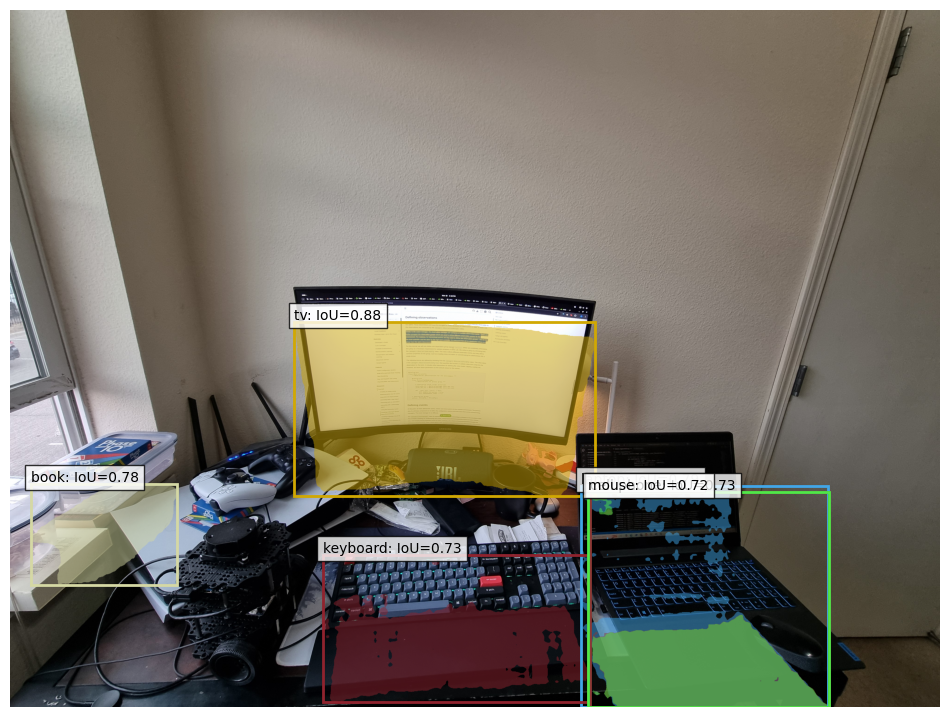

In [8]:
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        from transformers import SamModel, SamProcessor
        from PIL import Image
        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        import random
        from ultralytics import YOLO

        # Check if CUDA is available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load the SlimSAM model and processor
        def load_slimsam_model():
            model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50")
            processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")
            model.eval()
            model.to(device)
            return model, processor

        # Load a pre-trained YOLOv8 model for object detection and classification
        def load_yolo_model():
            model = YOLO("yolov8n.pt")  # YOLOv8 nano model (lightweight)
            return model

        # Detect objects, generate prompts, and get class names using YOLO
        def detect_objects_and_generate_prompts(image_path, yolo_model):
            image = Image.open(image_path).convert('RGB')
            width, height = image.size
            
            # Run YOLO to detect objects
            results = yolo_model(image)
            
            # Extract bounding boxes, center points (prompts), and class names
            input_points = []
            class_names = []
            for result in results:
                boxes = result.boxes.xyxy.cpu().numpy()  # [x_min, y_min, x_max, y_max]
                classes = result.boxes.cls.cpu().numpy()  # Class indices
                names = result.names  # Dictionary mapping class indices to names
                for box, cls in zip(boxes, classes):
                    x_min, y_min, x_max, y_max = box
                    center_x = (x_min + x_max) / 2
                    center_y = (y_min + y_max) / 2
                    input_points.append([center_x, center_y])
                    class_names.append(names[int(cls)])  # Get class name from index
            
            return input_points, class_names, image

        # Preprocess the image with a single prompt for SlimSAM
        def preprocess_image(image, input_point, processor):
            width, height = image.size
            
            # Shape: (batch_size, point_batch_size, num_points_per_image, 2)
            input_point = np.array([input_point]).reshape(1, 1, 1, 2)  # Shape: (1, 1, 1, 2)
            input_point = torch.tensor(input_point, dtype=torch.float32)
            
            # Create input labels: 1 for foreground point
            input_labels = torch.ones((1, 1, 1), dtype=torch.int)
            
            # Process the image with the prompt
            inputs = processor(image, input_points=input_point, input_labels=input_labels, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            input_point = input_point.to(device)
            
            return inputs, input_point

        # Perform segmentation with SlimSAM
        def get_predictions(model, inputs):
            with torch.no_grad():
                outputs = model(**inputs)
            return outputs

        # Compute bounding box from a binary mask
        def get_bounding_box(mask_binary):
            rows = np.any(mask_binary, axis=1)
            cols = np.any(mask_binary, axis=0)
            if not np.any(rows) or not np.any(cols):
                return None  # No mask found
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]
            return [cmin, rmin, cmax, rmax]  # [x_min, y_min, x_max, y_max]

        # Visualize segmented regions overlaid on the original image
        def visualize_results(image, outputs_list, processor, input_points_list, class_names, score_threshold=0.7, alpha=0.5):
            image_np = np.array(image)  # Original image as numpy array
            height, width, _ = image_np.shape
            overlay = image_np.copy()  # Copy of original image for overlay
            
            plt.figure(figsize=(12, 12))
            ax = plt.gca()
            
            # Process each object's mask and metadata
            for idx, (outputs, input_points, class_name) in enumerate(zip(outputs_list, input_points_list, class_names)):
                masks = processor.image_processor.post_process_masks(
                    outputs.pred_masks.cpu(),
                    inputs["original_sizes"].cpu(),
                    inputs["reshaped_input_sizes"].cpu()
                )[0]  # First batch of masks
                
                iou_scores = outputs.iou_scores.cpu().numpy().flatten()
                input_points = input_points.cpu().numpy().reshape(-1, 1, 2)
                
                for i, (mask, score, prompt) in enumerate(zip(masks, iou_scores, input_points)):
                    score_float = score.item()
                    mask_np = mask.numpy()
                    
                    if score_float > score_threshold:
                        if len(mask_np.shape) == 3:
                            mask_np = mask_np[0]  # Select first channel if multi-channel
                        
                        # Resize mask to match image dimensions
                        mask_scaled = (mask_np * 255).astype(np.uint8)
                        mask_pil = Image.fromarray(mask_scaled).resize((width, height), Image.BILINEAR)
                        mask_resized = np.array(mask_pil) / 255.0
                        
                        # Generate random color
                        random_color = [random.randint(0, 255) for _ in range(3)]
                        random_color_float = [c / 255.0 for c in random_color]
                        
                        # Create binary mask
                        mask_binary = np.where(mask_resized > 0.5, 1, 0).astype(np.uint8)
                        
                        # Overlay the mask on the original image with transparency
                        for c in range(3):  # Apply color to each channel
                            overlay[:, :, c] = np.where(
                                mask_binary == 1,
                                overlay[:, :, c] * (1 - alpha) + random_color[c] * alpha,
                                overlay[:, :, c]
                            )
                        
                        # Compute bounding box
                        bbox = get_bounding_box(mask_binary)
                        if bbox is None:
                            continue
                        
                        # Draw bounding box
                        rect = patches.Rectangle(
                            (bbox[0], bbox[1]),
                            bbox[2] - bbox[0],
                            bbox[3] - bbox[1],
                            linewidth=2,
                            edgecolor=random_color_float,
                            facecolor='none'
                        )
                        ax.add_patch(rect)
                        
                        # Add class name and IoU score as text
                        plt.text(bbox[0], bbox[1] - 10,
                                f'{class_name}: IoU={score_float:.2f}',
                                bbox=dict(facecolor='white', alpha=0.8),
                                fontsize=10, color='black')
            
            # Display the original image with overlay
            plt.imshow(overlay)
            plt.axis('off')
            plt.show()

        # Main function for inference
        def main(image_path):
            # Load models
            slim_model, processor = load_slimsam_model()
            yolo_model = load_yolo_model()
            
            # Detect objects and get prompts and class names
            input_points, class_names, image = detect_objects_and_generate_prompts(image_path, yolo_model)
            
            if not input_points:
                print("No objects detected in the image.")
                return
            
            # Process each object individually
            outputs_list = []
            input_points_list = []
            for i, point in enumerate(input_points):
                print(f"Processing object {i + 1}/{len(input_points)}: {class_names[i]}")
                inputs, input_point = preprocess_image(image, point, processor)
                outputs = get_predictions(slim_model, inputs)
                outputs_list.append(outputs)
                input_points_list.append(input_point)
            
            # Visualize all results overlaid on the original image
            visualize_results(image, outputs_list, processor, input_points_list, class_names)

        if __name__ == "__main__":
            image_path = "Picture8.jpg"  # Replace with your image path
            main(image_path)
        output = model(**inputs)

In [8]:
masks = processor.image_processor.post_process_masks(
    output.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)